## Test Naive Bayes (Fake vs Real news) model generalisation

## Adopted the notebook of Victoria for generalisation

Disaster-Tweets: Searching Real Tweets 
https://www.kaggle.com/datasets/vstepanenko/disaster-tweets

### Import libraries

In [1]:
import pandas as pd # data processing 
import matplotlib.pyplot as plt # plotting 
import numpy as np # linear algebra 
import seaborn as sns 

# tool to read data csv file (it is faster than pandas and can read files from .zip)
# import datatable as dt

import kaggle

# colored output text
from termcolor import colored

import re
import string 

from bs4 import BeautifulSoup

# from wordcloud import WordCloud, STOPWORDS

# module implements binary protocols for serializing and de-serializing a Python object
import pickle

# natural language toolkit (https://realpython.com/nltk-nlp-python/)
# (https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/)
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

# filter common words
from nltk.corpus import stopwords
# split text into words
from nltk.tokenize import word_tokenize
# nltk.download('averaged_perceptron_tagger')

# reduce words to their root by transformin to initial form with ectual meaning (ex. goes -> go )
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('omw-1.4')

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

# Silent warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#for count vectorizer and naive bayes model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import text


### Search for datasets

In [2]:
#search for the dataset
# !kaggle datasets list -s 'fake-tweets'

### Dowload datasets

In [3]:
# # https://www.kaggle.com/datasets/ruchi798/source-based-news-classification
# !kaggle datasets download 


In [4]:
# !mv source-based-news-classification.zip data

### Read dataset

In [5]:
raw_df = pd.read_csv('tweets.csv')
raw_df.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


### Drop redundant features

In [6]:
df = raw_df[['text', 'target']].copy()
df.head()

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11370 non-null  object
 1   target  11370 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 177.8+ KB


In [8]:
#real tweets = 1, fake = 0
df.groupby('target').count()

,text
target,
0,9256
1,2114


In [9]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [10]:
df[df['target']== '']

,text,target


In [11]:
# df['target'].replace({'Real': 1, 'Fake': 0}, inplace=True)
# df.head()

### Plot label count

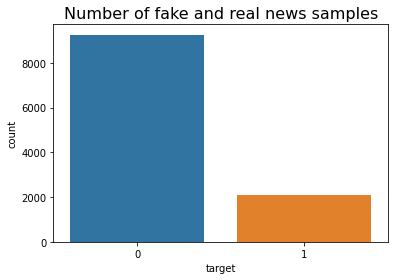

In [12]:
sns.countplot(x='target', data=df)
plt.title('Number of fake and real news samples', fontdict={'fontsize':16})
plt.show()

### Create function to clean data

In [13]:
def remove_duplicates(df):
    shape_before = df.shape
    # check if there are duplicates
    duplicate = df['text'][df['text'].duplicated()].index
    text = f"Found {len(duplicate)} duplicate in {df.shape[0]} samples"
    print(colored(text, 'blue', attrs=['bold']))
    # remove duplicates
    df.drop(index=duplicate, inplace=True)
    text = f"Data shape before {shape_before}, after {df.shape}"
    print(colored(text, 'green', attrs=['bold']))
    return df


def remove_Reuters(df):
    shape_before = df.shape
    pattern = r'[A-Z]* ?\(Reuters\)'
    
    # check if <CITY> (Reuters) in text
    test_df = df['text'].copy().to_frame()
    test_df['patterns'] = test_df['text'].map(lambda x: len(re.findall(pattern, x)))
    if any(test_df['patterns'] > 0):
        text = f"{test_df.groupby('patterns')['text'].count()[1]} of {test_df.shape[0]} samples have <City> (REUTERS) pattern."
        print(colored(result, 'blue', attrs=['bold'])) 
        # remove
        df['text'] = df['text'].map(lambda x: re.sub(pattern, '', x))
        text = f"Data shape before {shape_before}, after {df.shape}"
        print(colored(text, 'green', attrs=['bold']))
    return df


def remove_links(df):
    pattern = r'https?://[^\n ]*'

    # find how many samples have links in text
    test_df = df['text'].copy().to_frame()
    test_df['patterns'] = test_df['text'].map(lambda x: len(re.findall(pattern, x)))
    if any(test_df['patterns'] > 0):
        text = f"{test_df.groupby('patterns')['text'].count()[1]} of {df.shape[0]} samples have link"
        print(colored(text, 'blue', attrs=['bold']))

        df['text'] = df['text'].map(lambda x: re.sub(pattern, '', x))
    return df


def remove_tags(text):  
    # parse html content
    soup = BeautifulSoup(text, "html.parser")
  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
  
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)


def remove_empty_text(df):
    shape_before = df.shape
    
    text = f"Found {df[df['text'].str.strip()==''].count()[1]} empty values of text"
    print(colored(text, 'blue', attrs=['bold']))
    
    df = df[df['text'].str.strip()!='']
    text = f"Data shape before {shape_before}, after {df.shape}"
    print(colored(text, 'green', attrs=['bold']))
    return df

def remove_empty_label(df):
    shape_before = df.shape
    
    text = f"Found {df[df['target']==''].count()[1]} empty values of label"
    print(colored(text, 'blue', attrs=['bold']))
    
    df = df[df['target']!='']
    text = f"Data shape before {shape_before}, after {df.shape}"
    print(colored(text, 'green', attrs=['bold']))
    return df


def clean_df(df):
    # remove duplicates
    df = remove_duplicates(df)
    
    # remove source in form of <CITY> (Reuters) if any 
    df = remove_Reuters(df)
    
    # remove links (http/https) 
    df = remove_links(df)      
    
    # remove HTML
    df['text'] = df['text'].map(lambda x: remove_tags(x))
    
    # remove empty text values
    df = remove_empty_text(df)
    
    # remove empty label values
    df = remove_empty_label(df)    
    return df    

In [14]:
df = clean_df(df)
df.head()

Found 147 duplicate in 11370 samples
Data shape before (11370, 2), after (11223, 2)
5110 of 11223 samples have link
Found 2 empty values of text
Data shape before (11223, 2), after (11221, 2)
Found 0 empty values of label
Data shape before (11221, 2), after (11221, 2)


,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership,1
3,Arsonist sets cars ablaze at dealership,1
4,"""Lord Jesus, your love brings freedom and pard...",0


### Wordcloud plot

In [15]:
# fake_ = df.text[df['label']==0]
# real_ = df.text[df['label']==1]

# def plot_fake_vs_real(fake, real):
#     wordcloud_fake = WordCloud(width = 2000, height = 1300,
#                               background_color = 'white', 
#                               stopwords = STOPWORDS).generate(str(fake))
#     wordcloud_real = WordCloud(width = 2000, height = 1300,
#                               background_color = 'white', 
#                               stopwords = STOPWORDS).generate(str(real))
    
#     # plot WordCloud img 
#     plt.subplots(figsize=(15,6))
    
#     plt.subplot(1,3,1)
#     plt.imshow(wordcloud_fake, interpolation = 'bilinear')
#     plt.axis('off')
#     plt.tight_layout(pad=0)
    
#     plt.suptitle("Fake(left) vs Real(right)", y=0.5, va='center', size = 24)
    
#     plt.subplot(1,3,3)
#     plt.imshow(wordcloud_real, interpolation = 'bilinear')
#     plt.axis('off')
#     plt.tight_layout(pad=0)

    
# plot_fake_vs_real(fake_, real_)
# plt.show()      

### Save cleaned dataset

In [16]:
cleaned_df = df[['text', 'target']].copy()
cleaned_df.to_csv('cleaned_tweets_data.csv', index=False, encoding='utf-8')

### Load cleaned dataset

In [17]:
test_df = pd.read_csv('cleaned_tweets_data.csv')
test_df.head()

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership,1
3,Arsonist sets cars ablaze at dealership,1
4,"""Lord Jesus, your love brings freedom and pard...",0


### Preprocess (remove stopwords, tag, lemmatize) 

In [18]:
# simplifies position of speech tags

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None


def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
 
    # tokenize text into words, clean of punctuation and stopwords
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]  

    # tokenize text including position of speech
    text = nltk.pos_tag(text)   
    text = list(map(lambda x: (x[0], pos_tagger(x[1])), text))

    # lemmatize words with respect to position of speech
    text_ = []    
    for word, tag in text:
        if tag is None:
            text_.append(word)
        else:
            text_.append(lemma.lemmatize(word, tag))
    text = ' '.join(text_) 
    return text

In [19]:
test_df['text'] = test_df['text'].apply(preprocess_text)
test_df.head()

,text,target
0,"Communal violence Bhainsa , Telangana . `` Sto...",1
1,Telangana : Section 144 impose Bhainsa January...,1
2,Arsonist set car ablaze dealership,1
3,Arsonist set car ablaze dealership,1
4,"`` Lord Jesus , love brings freedom pardon . F...",0


### Separate dependent variable

In [20]:
X = test_df['text'].values
y = test_df['target'].values

# X.shape, y.shape

### Vectorize data

In [21]:
# load vectorizer from pickle file (previously fitted on train data)
with open('CountVectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)
    
# transform data
all_words = vectorizer.fit_transform(df.text.values.astype('U'))

In [22]:
all_words.shape   


(11221, 21320)

In [23]:
vectorizer.vocabulary_


{'communal': 4252,
 'violence': 20240,
 'bhainsa': 2488,
 'telangana': 18766,
 'stones': 18048,
 'pelted': 14068,
 'muslims': 12654,
 'houses': 9171,
 'vehicles': 20095,
 'set': 16889,
 'ablaze': 733,
 'section': 16729,
 '144': 125,
 'imposed': 9510,
 'january': 10144,
 '13': 107,
 '15': 137,
 'clash': 3966,
 'erupted': 6668,
 'groups': 8409,
 '12': 95,
 'po': 14497,
 'arsonist': 1673,
 'sets': 16893,
 'cars': 3466,
 'dealership': 5178,
 'lord': 11373,
 'jesus': 10214,
 'love': 11408,
 'brings': 3022,
 'freedom': 7718,
 'pardon': 13883,
 'holy': 9049,
 'spirit': 17780,
 'heart': 8792,
 'child': 3804,
 'chinese': 3824,
 'tweet': 19618,
 'gone': 8209,
 'viral': 20248,
 'social': 17527,
 'media': 11981,
 'snl': 17493,
 'racist': 15278,
 'ngemsibaa': 13006,
 'village': 20217,
 'oku': 13425,
 'sub': 18194,
 'division': 5880,
 'north': 13154,
 'west': 20569,
 'region': 15664,
 'cameroon': 3346,
 'asansol': 1697,
 'bjp': 2597,
 'office': 13390,
 'salanpur': 16415,
 'night': 13048,
 'alleged':

In [24]:
label=df["target"]  #renaming for better readability

In [25]:
x_train, x_test, y_train, y_test = train_test_split(all_words, label, test_size=0.2, random_state=75)

### Predict fake vs real news using pretrained Logistic Regression model

In [26]:
# load trained algorithm
with open('MultinomialNB.pkl', 'rb') as file:
    MultinomialNB = pickle.load(file)

In [27]:
classifier = MultinomialNB()

In [28]:
classifier.fit(x_train, y_train) #training the model with our CV-d text data and labels

MultinomialNB()

### Print classification report 

In [29]:
print(classification_report(y_test, classifier.predict(x_test)))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1859
           1       0.56      0.67      0.61       386

    accuracy                           0.85      2245
   macro avg       0.74      0.78      0.76      2245
weighted avg       0.86      0.85      0.86      2245



### Plot confusion matrix

<AxesSubplot:>

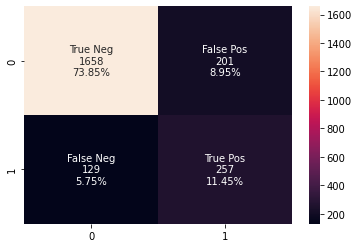

In [30]:
cm = confusion_matrix(y_test, classifier.predict(x_test))

sns.set_palette(palette='flare')

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="")

### Plot Receiver operating characteristic (ROC) curve

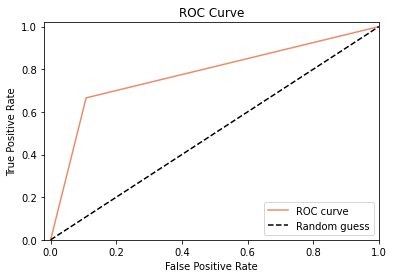

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict(x_test))
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")